In [1]:
import numpy as np
import pandas as pd
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
data_root = '/kaggle/input/testtttt/smoking_classification'
print(os.listdir(data_root))

['train']


# Разделение датасета на валидационную и тренировочную выборки.

In [3]:
train_dir = 'train'
val_dir = 'val'
each_val_img_ind = 5 # каждое пятое изображение в валидацию

class_names = ['notsmoking', 'smoking']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % each_val_img_ind  != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 1038/1038 [00:05<00:00, 191.93it/s]


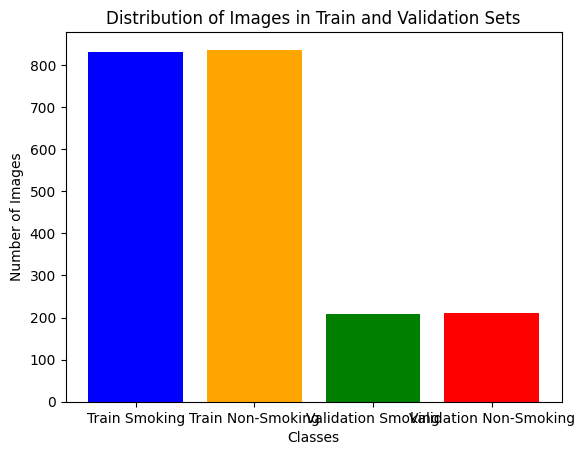

In [4]:
def print_data():
    train_smoking = len(os.listdir('/kaggle/working/train/smoking'))
    train_nonsmoking = len(os.listdir('/kaggle/working/train/notsmoking'))
    val_smoking = len(os.listdir('/kaggle/working/val/smoking'))
    val_nonsmoking = len(os.listdir('/kaggle/working/val/notsmoking'))
    labels = ['Train Smoking', 'Train Non-Smoking', 'Validation Smoking', 'Validation Non-Smoking']
    values = [train_smoking, train_nonsmoking, val_smoking, val_nonsmoking]
    plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title('Distribution of Images in Train and Validation Sets')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()
print_data()

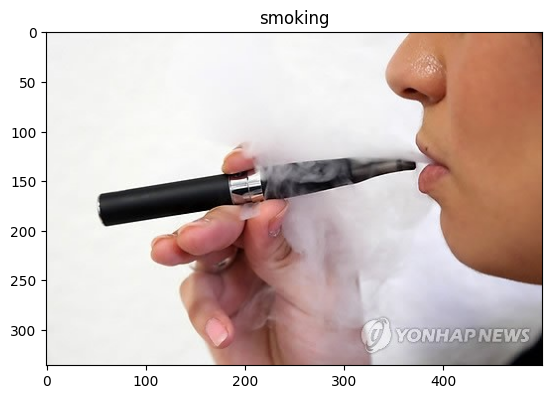

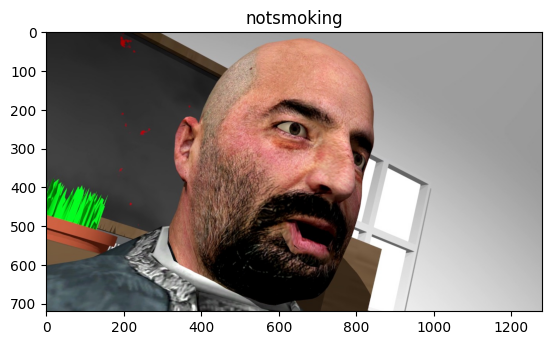

In [5]:
from PIL import Image
def show_random_image(image_folder):
    image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
    random_image_path = random.choice(image_paths)
    folder_name = os.path.basename(os.path.dirname(random_image_path))
    image = Image.open(random_image_path)
    plt.imshow(image)
    plt.title(folder_name)
    plt.show()
    plt.pause(0.001)
show_random_image('/kaggle/working/train/smoking')
show_random_image('/kaggle/working/train/notsmoking')

# Предобработка датасета: применение аугментаций для датасета соревнования и open source.

In [6]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms.functional import adjust_brightness
from PIL import Image
image_folders_train = ["/kaggle/working/train/smoking", "/kaggle/working/train/notsmoking"]

# Аугментации к open source датасету
train_transforms_data_all = [
    transforms.Compose([
        transforms.RandomRotation(60),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.RandomGrayscale(p=1),
        transforms.RandomOrder([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ]),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.RandomInvert(),
        transforms.ToTensor(),
]), 
     transforms.Compose([
        transforms.GaussianBlur(kernel_size=3),  # Применение гауссовского размытия
        transforms.ToTensor(),
    ]),
]
#Аугментации к датасету соревнования

# Определение функции для уменьшения яркости изображения
def reduce_brightness(image, factor):
    return adjust_brightness(image, factor)

train_transforms_dataset_source = [
    transforms.Compose([
        transforms.CenterCrop(1000),
        transforms.RandomGrayscale(p=1),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.CenterCrop(1000),
        transforms.Lambda(lambda x: reduce_brightness(x, 0.5)),  # Уменьшение яркости на 0.5
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.CenterCrop(100),
        transforms.Lambda(lambda x: reduce_brightness(x, 0.3)),  # Уменьшение яркости на 0.3,
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
]

augment_number = 25

for image_folder in image_folders_train:
    for index_image, filename in enumerate(os.listdir(image_folder)):
        # Получение пути к текущему изображению
        image_path = os.path.join(image_folder, filename)

        if not filename.startswith('data_') and index_image % augment_number == 0:
            # Применение аугментаций
            for index, transform in enumerate(train_transforms_data_all):
                augmented_image = transform(Image.open(image_path))

                # Получение имени файла без расширения
                name, ext = os.path.splitext(filename)

                # Формирование имени аугментированного файла
                augmented_filename = f"{name}_{index}_augmented{ext}"

                # Сохранение аугментированного изображения
                output_path = os.path.join(image_folder, augmented_filename)
                save_image(augmented_image, output_path)
        elif filename.startswith('data_'):
            for index, transform in enumerate(train_transforms_dataset_source):
                augmented_image = transform(Image.open(image_path))

                name, ext = os.path.splitext(filename)

                augmented_filename = f"{name}_{index}_augmented{ext}"

                output_path = os.path.join(image_folder, augmented_filename)
                save_image(augmented_image, output_path)

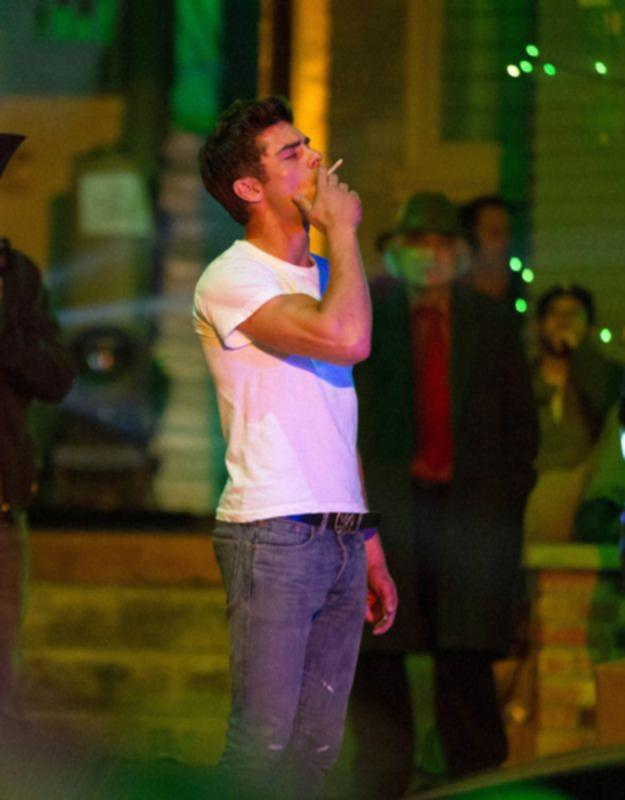

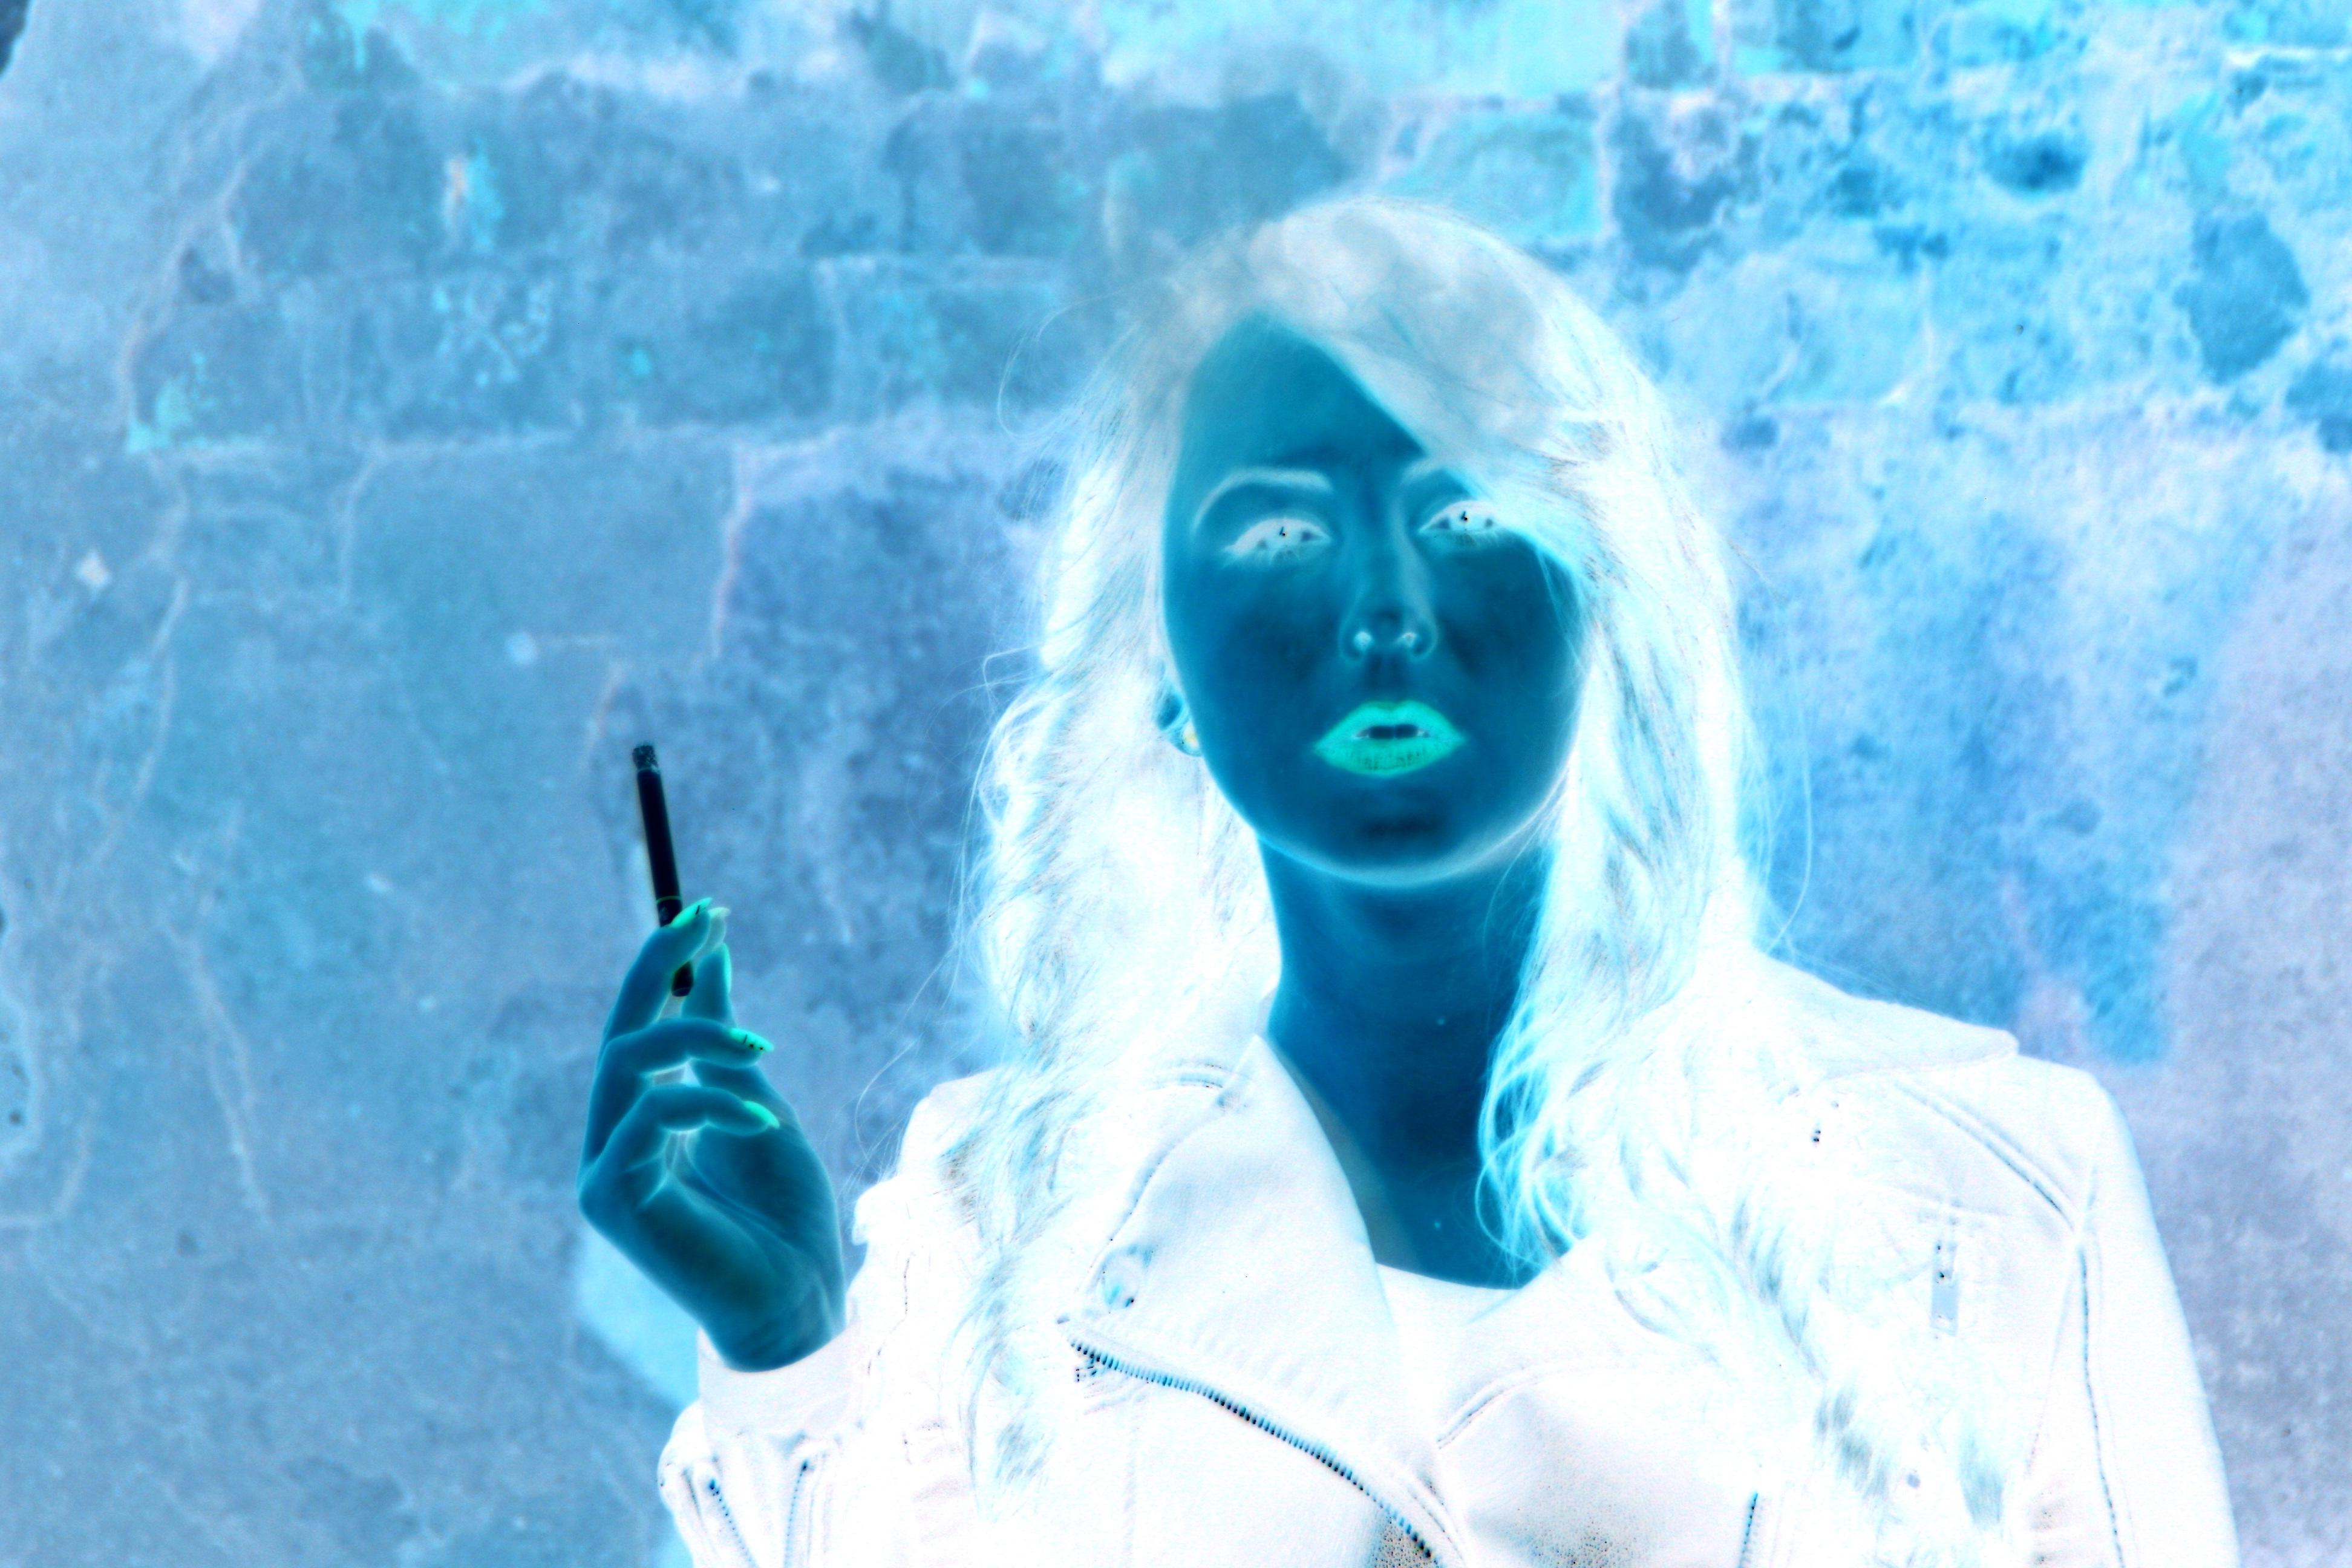

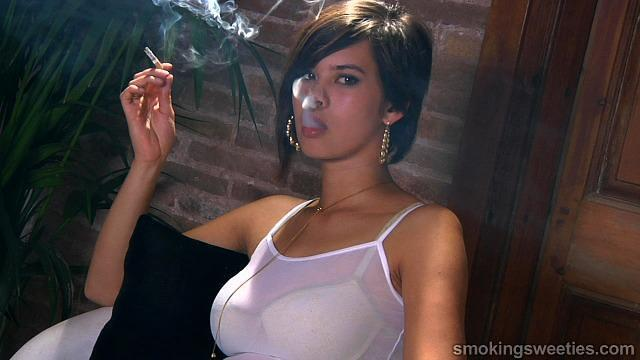

In [7]:
from IPython.display import display, Image
print_image = 3
total  = 0
image_folger = '/kaggle/working/train/smoking'
for filename in os.listdir(image_folger):
    if '_augmented' in filename:
        if total == print_image:
            break
        total+=1
        image_path = os.path.join(image_folger, filename)
        display(Image(filename=image_path, height=400))
        print("\n")

# Обучение нейросети.

In [8]:
!pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5689.3/8062.4 GB disk)


In [9]:
import torch
!nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mon Jul  1 12:31:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
import os

# Текущее имя файла
old_file_name = "/kaggle/working/new/test"

# Новое имя файла
new_file_name = "/kaggle/working/new/val"

# Переименование файла
os.rename(old_file_name, new_file_name)

print("Файл успешно переименован.")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/new/test' -> '/kaggle/working/new/val'

In [ ]:
!pip install wandb

In [ ]:
import os
from ultralytics import YOLO

# Проверьте, что файл YAML существует
yaml_file = '/kaggle/input/testtttt/smoking_classification'

if not os.path.exists(yaml_file):
    raise FileNotFoundError(f"The file {yaml_file} does not exist. Please check the path.")

# Загрузка модели
model = YOLO("yolov8l-cls.pt")
model.to("cpu")  # или "cuda", если используете GPU

# Обучение модели
results = model.train(
    data=yaml_file,  # Убедитесь, что путь правильный
    epochs=25,
    imgsz=128,
    batch=8,
    name='yolov8n_custom'
)

In [ ]:
DATA_DIR='/kaggle/working/mage'
model = YOLO("yolov8l-cls.pt")
model.to(device)
results = model.train(data=f'{DATA_DIR}', epochs=25, imgsz=128)

In [ ]:
!yolo task=classify mode=train data={'/kaggle/working'}

In [ ]:
Image(filename=f'/kaggle/working/runs/classify/val/confusion_matrix.png')

In [ ]:
Image(filename=f'/kaggle/working/runs/classify/train/confusion_matrix.png')

In [ ]:
results_path = '/kaggle/working/runs/classify/train/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

# Получение предикта на тесте.

In [ ]:
# вставьте папку с изображениями для теста : название/img1, img2...
# test = ''


In [ ]:
!rm /kaggle/working/new/train.cache

In [ ]:
import os
os.environ["WANDB_MODE"] = "offline"
!yolo task=classify mode=train conf=0.25 data=/kaggle/working/mage

In [ ]:
from pathlib import Path
# Путь к папке
folder_path = Path('/kaggle/working/new/val/notsmoking')

# Флаг, указывающий, все ли файлы имеют расширение jpg/jpeg
all_jpg = True

# Проверяем каждый файл в папке
for file in folder_path.iterdir():
    if not (file.suffix.lower() == '.jpg' or file.suffix.lower() == '.jpeg'):
        all_jpg = False
        print(f"Несоответствующий файл: {file.name}")
        break

if all_jpg:
    print("Все файлы имеют тип .jpg или .jpeg")
else:
    print("Не все файлы имеют тип .jpg или .jpeg")

In [ ]:
!yolo task=classify mode=predict conf=0.25 source={/kaggle/working/val} model=/kaggle/working/runs/classify/train2/weights/best.pt

In [ ]:
!yolo task=classify mode=val conf=0.25 source={/kaggle/working/val} =/kaggle/working/runs/classify/train2/weights/best.pt

In [ ]:
!yolo task=classify mode=predict model=/kaggle/working/runs/classify/train/weights/best.pt conf=0.25 source={test}

In [ ]:
import glob

model = YOLO(f'/kaggle/working/runs/classify/train/weights/best.pt')
submissions = dict()  

file_list = os.listdir(test)
file_list.sort()

for image_path in file_list:
    filename = os.path.join(test, image_path)
    result = model( filename)
    probs = result[0].probs.data.tolist()
    name = result[0].names
    submissions[image_path] = max(zip(list(name.values()), probs), key=lambda x: x[1])[0]

submissionss = pd.Series(submissions)
submissionss.to_csv('submissions.csv')

In [ ]:
for image_path in glob.glob(f'/kaggle/working/runs/classify/predict/*.jpg')[:3]:
    display(Image(filename=image_path, height=300))
    print("\n")

# Детекция человека.

In [ ]:
!pip install git+https://github.com/Deci-AI/super-gradients.git@stable

In [ ]:
import pathlib
from super_gradients.training import models
from super_gradients.common.object_names import Models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.get("yolo_nas_pose_l", pretrained_weights="coco_pose")
model.to(device)

In [ ]:
import shutil
import os

# Путь к директории, которую нужно удалить
directory_to_delete = '/kaggle/working/new'

# Проверка существования директории
if os.path.exists(directory_to_delete):
    # Удаление всей директории вместе с её содержимым
    shutil.rmtree(directory_to_delete)
    print(f"Директория '{directory_to_delete}' удалена.")
else:
    print(f"Директория '{directory_to_delete}' не существует.")

In [ ]:

from PIL import Image

# Папка с изображениями для предсказания
folder_path = '/kaggle/working/val'

# Папка для сохранения предсказанных изображений
output_folder = '/kaggle/working/mage'

# Создание папки для сохранения предсказанных изображений, если её ещё нет
#os.makedirs(output_folder, exist_ok=True)

# Проход по каждому файлу в папке с изображениями для предсказания
for class_name in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_name)
    if os.path.isdir(class_path):
        # Создание папки для класса, если её ещё нет
        output_class_folder = os.path.join(output_folder, class_name)
        os.makedirs(output_class_folder, exist_ok=True)
        # Проход по каждому файлу в папке (изображениям)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            # Предобработка изображения
            #image = Image.open(image_path)
            # Предсказание модели
            confidence = 0.6
            output = model.predict(image_path, conf=confidence)
            # Сохранение прогнозов в output
            output.save(f'/kaggle/working/mage/train/{class_name}/{filename}_prediction.jpg')

In [ ]:
def show_random_image(image_folder, submissions):
    image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
    random_image_path = random.choice(image_paths)
    image_name = random_image_path.split('new/')[1]
    image = Image.open(random_image_path)
    plt.imshow(image)
    plt.title(submissions[image_name])
    plt.show()
    plt.pause(0.001)

show_random_image('/kaggle/working/new', submissions)
show_random_image('/kaggle/working/new', submissions)

In [ ]:
files = os.listdir('/kaggle/working')

# Удаляем каждый файл и директорию
for file in files:
    if os.path.isfile(file):
        os.remove(file)  # Удалить файл
    else:
        shutil.rmtree(file)  # Удалить директорию